# Random Forest Algorithm with Feedback for Arm-Use Detection

This notebook trains and tests random forest algorithm with output feedback for arm-use detection. The algorithm is trained on the data from the study by Dr Ann David [1].

[1] David, Ann, et al. "Quantification of the relative arm use in patients with hemiparesis using inertial measurement units." Journal of Rehabilitation and Assistive Technologies Engineering 8 (2021): 20556683211019694.

### Getting the data

If you do not already have the data to run this this notebook, 
you need to download it from here.  https://github.com/biorehab/upper-limb-use-assessment



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer

In [3]:
from matplotlib.ticker import MaxNLocator

### Custom Modules

In [4]:
sys.path.append("../scripts")

# import classification_algorithms as ca
# import reduced_models as rm
# import task_analysis as ta

import misc

In [5]:
# import gmac

In [6]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight


## Define notebook level constants

In [7]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)
DATADIR = "../../gmac/data"
OUTDIR = "../output/"
OUTDIRDATA = OUTDIR + "data/"

## Read the Controls and Patients Data

In [8]:
# Read all healthy and patient data.
datadf = misc.read_summarize_data(datadir=DATADIR, dT=dT)

### Generate the autocorrelation function of the UL use data

In [9]:
N = 4000
all_ul_summary = misc.genrate_ul_autocorr_summary(datadf, N=4000)

unaff,  5,  3

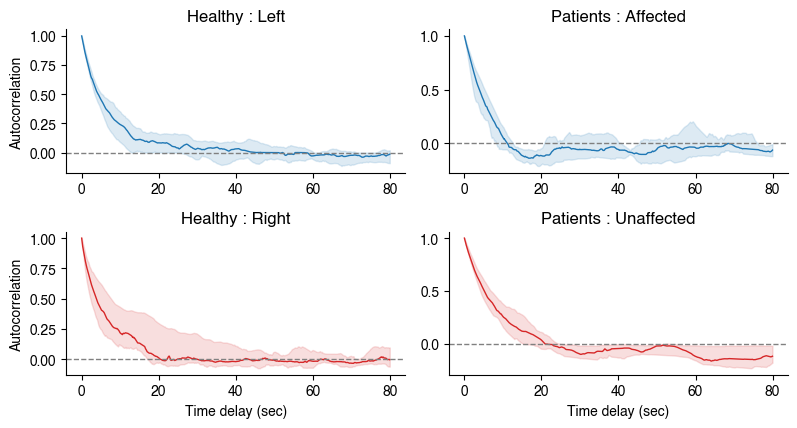

In [62]:
# Summary for healthy subjects
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(421)
_t = np.arange(N) * dT
q25 = np.percentile(all_ul_summary['left'], 25, axis=1)
q50 = np.percentile(all_ul_summary['left'], 50, axis=1)
q75 = np.percentile(all_ul_summary['left'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:blue")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:blue', alpha=0.15)
# ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
# ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Autocorrelation", fontsize=10)
ax.set_title("Healthy : Left", fontsize=12)

ax = fig.add_subplot(423)
q25 = np.percentile(all_ul_summary['right'], 25, axis=1)
q50 = np.percentile(all_ul_summary['right'], 50, axis=1)
q75 = np.percentile(all_ul_summary['right'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:red")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:red', alpha=0.15)
# ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
# ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Autocorrelation", fontsize=10)
ax.set_xlabel("Time delay (sec)", fontsize=10)
ax.set_title("Healthy : Right", fontsize=12)

ax = fig.add_subplot(422)
_t = np.arange(N) * dT
q25 = np.percentile(all_ul_summary['aff'], 25, axis=1)
q50 = np.percentile(all_ul_summary['aff'], 50, axis=1)
q75 = np.percentile(all_ul_summary['aff'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:blue")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:blue', alpha=0.15)
# ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
# ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Patients : Affected", fontsize=12)

ax = fig.add_subplot(424)
q25 = np.percentile(all_ul_summary['unaff'], 25, axis=1)
q50 = np.percentile(all_ul_summary['unaff'], 50, axis=1)
q75 = np.percentile(all_ul_summary['unaff'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:red")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:red', alpha=0.15)
# ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
# ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time delay (sec)", fontsize=10)
ax.set_title("Patients : Unaffected", fontsize=12)
plt.tight_layout()

# Save figure
plt.savefig(f"{OUTDIR}/ul_autocorrelation_summary.svg", bbox_inches="tight")
plt.savefig(f"{OUTDIR}/ul_autocorrelation_summary.png", bbox_inches="tight", dpi=300)

The above figure indicates that the process has memory that last up to 10-20 seconds. Note that this might be due to the choice of tasks used in this dataset. It would this make sense to use a window of size 5 seonds or less, where the current output is moderate to strong correlation with the past output. 

### Supporting functions

In [11]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

## RF with output feedback

#### Parameter ranges for the grid search

In [57]:
# Input and output feedback window sizes
Tin = 1.0
Nin = int(Tin / dT)
Tout = (dT, 0.1, 0.25, 0.5, 1.0)
Nout = tuple(map(lambda x: int(x / dT), Tout))

# Columns
raw_cols = ["subject", "segment", "ax", "ay", "az", "r1", "r2", "g1", "g2"]

In [63]:
# Compute the features for each segment for each subject.
data_features_df = misc.get_features_for_all(datadf, Nin, raw_cols)

[ 99 / 100] unaff  5  3

In [66]:
# Save the features data frame for the given Nin and Nout
for limb, df in data_features_df.items():
    df.to_csv(f"{OUTDIRDATA}/data_features_{limb}_{Nin}.csv", index=False)

# Limb-Specific Models - Training and Testing
This is implemented through nested cross-validation with leave-one-subject-out for 
both the outer and inner loops.

In [15]:
def generate_windowed_uluse(datadf, Nin):
    """Generates a windowed version of the uluse data.
    """
    _ulusew = datadf['uluse'].rolling(window=Nin, min_periods=1).mean().values
    _ulusew[_ulusew > 0.5] = 1.0
    _ulusew[_ulusew < 0.5] = 0.0
    _ulusew[_ulusew == 0.5] = np.random.choice([0, 1], size=np.sum(_ulusew == 0.5))
    return _ulusew

def outerloop_loso_split(limbdf, subcol):
    """Iterates over the leave-one-subject-out training and testing data.
    """
    for subj, subjdf in limbdf.groupby(subcol):
        yield (limbdf[limbdf[subcol] != subj], subjdf)

def innerloop_loso_split(train_df, subcol):
    """Iterates over the leave-one-segment-out training and validation data.
    """
    _tempdf = train_df.copy()
    _tempdf['inx'] = range(_tempdf.shape[0])
    folds = []
    for subj, subjdf in _tempdf.groupby(subcol):
        val_inx = subjdf['inx'].values
        train_inx = _tempdf[_tempdf[subcol] != subj]['inx'].values
        folds.append((train_inx, val_inx))
    return folds

# Define Youden index function
def youden_index_score(y_true, y_pred):
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Sensitivity (Recall for Positive Class)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Youden index
    youden_index = sensitivity + specificity - 1
    return youden_index

# Wrap it into a scorer
youden_scorer = make_scorer(youden_index_score, greater_is_better=True)

In [142]:
def process_limb_data(limbdf_full, Nin):
    """Generate the downsampled limb data with the delayed output feedback 
    columns."""
    # Downsample the data by Nin by going through each subject and segment.
    limbdf = pd.DataFrame(columns=limbdf_full.columns)
    for subject in limbdf_full['subject'].unique():
        for segment in limbdf_full['segment'].unique():
            _df = limbdf_full[(limbdf_full['subject'] == subject)
                                & (limbdf_full['segment'] == segment)]
            limbdf = pd.concat([limbdf, _df.iloc[::Nin, :]], ignore_index=True)
    return limbdf

In [ ]:
def get_past_output(y_test, ncurr, Npast):
    """Get the past output feedback values.
    """
    _fb = np.zeros(Npast)
    if ncurr> 0 and ncurr < Npast:
        _fb[:ncurr] = y_test[:ncurr][::-1]
    elif ncurr >= Npast:
        _fb = y_test[ncurr - Npast:ncurr][::-1]
    return _fb


def predict_uluse(X_test, y_test, bestest, Npast):
    """Compute the predicted UL use values for a segment of data.
    """
    for _n, _row in tqdm(enumerate(X_test)):
        # Row with the output feedback
        print(get_past_output(y_test, _n, Npast))
        _rowfb = np.hstack((_row, get_past_output(y_test, _n, Npast))).reshape(1, -1)
        y_test[_n] = bestest.predict(_rowfb)[0]
    return y_test

In [148]:
limb = "left"
outfbinx = 0
Noutfb = Nout[outfbinx] 

# Load the limb DF data.
limbdf_full = pd.read_csv(f"{OUTDIRDATA}/data_features_{limb}_{Nin}.csv", index_col=None)

# UL Use shifted output.
limbdf_full['uluse-1'] = limbdf_full['uluse'].shift(1, fill_value=0)

# Generate the moving average of the uluse column for each segment.
limbdf_full['ulusefb'] = 0
for _, _subjdf in limbdf_full.groupby("subject"):
    for _, _segdf in _subjdf.groupby("segment"):
        _segdf['ulusefb'] = _segdf['uluse-1'].rolling(window=Noutfb, min_periods=1).mean()
        limbdf_full.update(_segdf)

# Generate the downsampled limb data with the delayed output feedback columns.
limbdf = process_limb_data(limbdf_full, Nin)

# Save the downsampled limb data.
limbdf.to_csv(f"{OUTDIRDATA}/data_features_{limb}_{Nin}_downsampled.csv", index=False)

(2100.0, 2500.0)

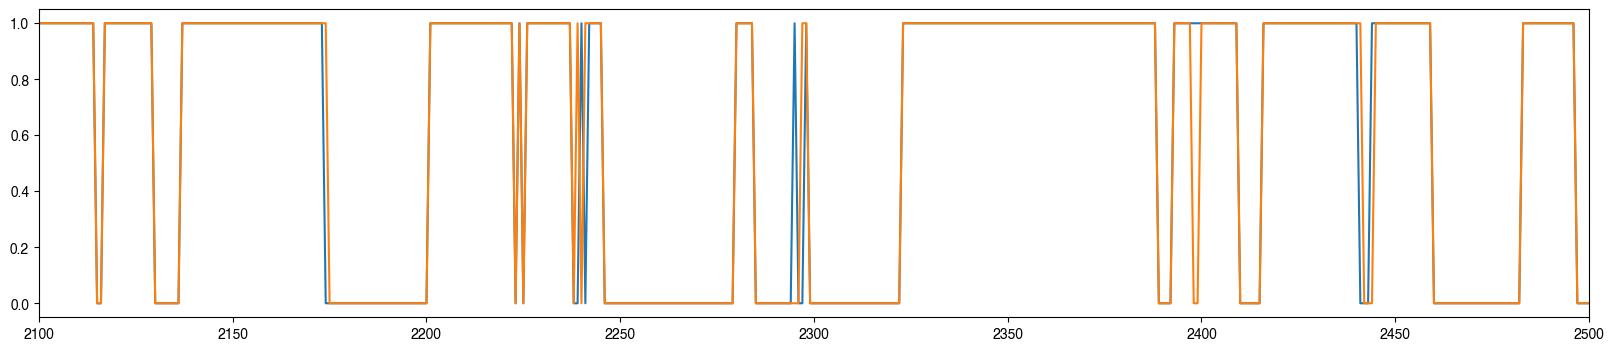

In [153]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
ax.plot(limbdf['uluse'].values)
ax.plot(limbdf[f'ulusefb'].values)
ax.set_xlim(2100, 2500)

In [154]:
# Input columns to retain
subcol = ['subject']
incol = ['mean_x', 'mean_y', 'mean_z', 'var_x', 'var_y', 'var_z', 'mean_2',
         'var_2', 'min_2', 'max_2', 'ent_2']
outcol = ['uluse']
outfbcol = ['ulusefb']
featcol = incol + outfbcol

In [156]:
# Random forest hyperparameter grid
param_grid = {'n_estimators': [100, 1000, 2000]}
classifier = RandomForestClassifier(class_weight="balanced")

In [157]:
limbdf = limbdf[subcol + featcol + outcol]
subj = []
bestest = []
limbdf_with_pred = pd.DataFrame(columns=limbdf.columns)
# Iterate over the leave-one-subject-out training and testing data.
_outerloop = outerloop_loso_split(limbdf, subcol[0])
for train_df, test_df in _outerloop:
    # Current test subject
    subj.append(test_df[subcol[0]].unique()[0])
    
    # Generate train and test data array.
    X_train = train_df[featcol].values
    y_train = train_df[outcol].values.reshape(-1)
    
    # Generate the inner-loop split
    _innerloop = innerloop_loso_split(train_df, subcol[0])
    print("dssd")
    # Now we are read to do grid search for hyperparameter tuning.
    grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=_innerloop, 
                               scoring=youden_scorer, n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)
    print("dss121d")

    # Best estimator
    bestest.append(grid_search.best_estimator_)

    # Predict UL use for the rest data using the best estimator. This however,
    # requires row-by-row evaluation because of the output feedback.
    # X_test = test_df[incol].values
    # y_test = np.zeros(X_test.shape[0])

    # test_df['ulusew_pred'] = predict_uluse(X_test, y_test, bestest[0], Nout[outfbinx])

    # test_df['ulusew_pred'] = grid_search.best_estimator_.predict(X_test)

    # # Append the test data with the predicted values
    # limbdf_with_pred = pd.concat([limbdf_with_pred, test_df], ignore_index=True)

    break

# Save the prediction data.
# limbdf_with_pred.to_csv(f"{OUTDIRDATA}/data_features_{limb}_{Nin}_downsampled_with_pred.csv", index=False)

dssd
Fitting 9 folds for each of 3 candidates, totalling 27 fits
[CV 2/9] END ..................n_estimators=100;, score=0.957 total time=   0.7s
[CV 1/9] END ..................n_estimators=100;, score=0.942 total time=   0.8s
[CV 8/9] END ..................n_estimators=100;, score=0.953 total time=   0.6s
[CV 3/9] END ..................n_estimators=100;, score=0.971 total time=   0.8s
[CV 4/9] END ..................n_estimators=100;, score=0.971 total time=   0.7s
[CV 5/9] END ..................n_estimators=100;, score=0.948 total time=   0.7s
[CV 7/9] END ..................n_estimators=100;, score=0.949 total time=   0.7s
[CV 6/9] END ..................n_estimators=100;, score=0.954 total time=   0.7s
[CV 9/9] END ..................n_estimators=100;, score=0.899 total time=   0.7s
[CV 7/9] END .................n_estimators=1000;, score=0.949 total time=   7.1s
[CV 5/9] END .................n_estimators=1000;, score=0.948 total time=   7.2s
[CV 3/9] END .................n_estimators=1

In [32]:
X_test = test_df[incol].values
y_test = np.zeros(X_test.shape[0])

test_df['ulusew_pred'] = predict_uluse(X_test, y_test, bestest[0], Nout[outfbinx])


1954it [00:15, 125.79it/s]


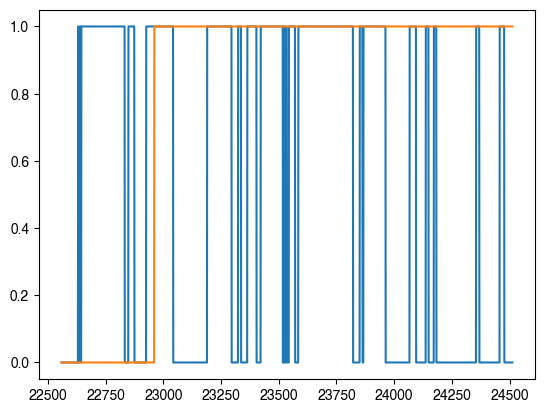

In [36]:
plt.plot(test_df['out'])
plt.plot(test_df['ulusew_pred'])

(300.0, 500.0)

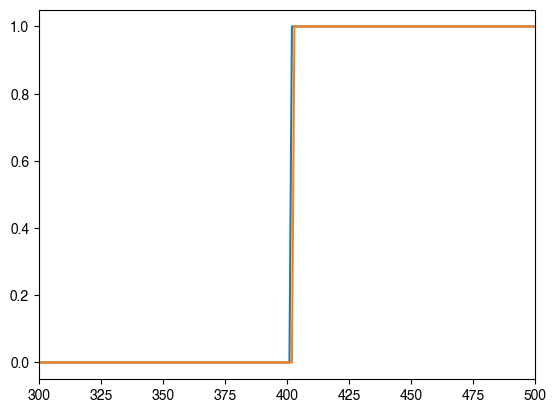

In [49]:
plt.plot(y_test)
plt.plot([get_past_output(y_test, _n, 1) for _n in range(len(y_test))])
plt.xlim(300, 500)

(500.0, 700.0)

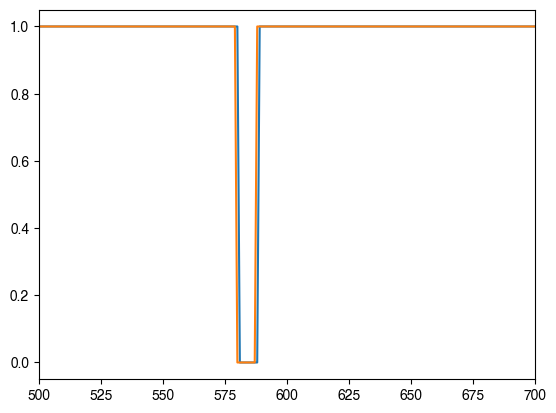

In [44]:
plt.plot(X_train[:, -1])
plt.plot(y_train)
plt.xlim(500, 700)

In [23]:
_innerloop

[(array([ 2427,  2428,  2429, ..., 22556, 22557, 22558]),
  array([   0,    1,    2, ..., 2424, 2425, 2426])),
 (array([    0,     1,     2, ..., 22556, 22557, 22558]),
  array([2427, 2428, 2429, ..., 4643, 4644, 4645])),
 (array([    0,     1,     2, ..., 22556, 22557, 22558]),
  array([4646, 4647, 4648, ..., 6816, 6817, 6818])),
 (array([    0,     1,     2, ..., 22556, 22557, 22558]),
  array([6819, 6820, 6821, ..., 8845, 8846, 8847])),
 (array([    0,     1,     2, ..., 22556, 22557, 22558]),
  array([ 8848,  8849,  8850, ..., 11500, 11501, 11502])),
 (array([    0,     1,     2, ..., 22556, 22557, 22558]),
  array([11503, 11504, 11505, ..., 13853, 13854, 13855])),
 (array([    0,     1,     2, ..., 22556, 22557, 22558]),
  array([13856, 13857, 13858, ..., 16595, 16596, 16597])),
 (array([    0,     1,     2, ..., 22556, 22557, 22558]),
  array([16598, 16599, 16600, ..., 20328, 20329, 20330])),
 (array([    0,     1,     2, ..., 20328, 20329, 20330]),
  array([20331, 20332, 20333, 

In [24]:
test_df

,subject,mean_x,mean_y,mean_z,var_x,var_y,var_z,mean_2,var_2,min_2,max_2,ent_2,out-1,out
22559,1,-0.676758,0.474121,-0.604980,0.000000,0.000000,0.000000,1.024106,0.000000,1.024106,1.024106,0.000000,0.0,0.0
22560,1,-0.720082,0.475941,-0.576882,0.000404,0.000062,0.000154,1.038424,0.000076,1.024106,1.057653,2.397894,0.0,0.0
22561,1,-0.717146,0.475981,-0.579404,0.000242,0.000042,0.000121,1.037742,0.000045,1.024106,1.057653,3.044522,0.0,0.0
22562,1,-0.716041,0.477004,-0.579889,0.000169,0.000040,0.000088,1.037674,0.000041,1.024106,1.057653,3.433987,0.0,0.0
22563,1,-0.717095,0.475241,-0.579590,0.000145,0.000068,0.000077,1.037425,0.000037,1.024106,1.057653,3.713572,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24508,1,-0.986240,0.138730,-0.277930,0.023896,0.049030,0.027076,1.068200,0.026643,0.817357,1.466535,3.891440,0.0,0.0
24509,1,-0.946719,0.072539,-0.301875,0.015125,0.022614,0.029409,1.022129,0.014005,0.817357,1.318944,3.901007,0.0,0.0
24510,1,-0.958271,0.117734,-0.299668,0.016753,0.024019,0.028026,1.037961,0.012250,0.829467,1.318944,3.901556,0.0,0.0
24511,1,-0.933828,0.131855,-0.303027,0.009584,0.019377,0.023238,1.012463,0.007468,0.829467,1.269114,3.905604,0.0,0.0


In [29]:
incol

['mean_x',
 'mean_y',
 'mean_z',
 'var_x',
 'var_y',
 'var_z',
 'mean_2',
 'var_2',
 'min_2',
 'max_2',
 'ent_2']

In [25]:
X_test = test_df[incol].values
y_test = np.zeros(X_test.shape[0])

predict_uluse(X_test, y_test, bestest[0], Nout[outfbinx])

In [26]:
test_df

,subject,mean_x,mean_y,mean_z,var_x,var_y,var_z,mean_2,var_2,min_2,max_2,ent_2,out-1,out
22559,1,-0.676758,0.474121,-0.604980,0.000000,0.000000,0.000000,1.024106,0.000000,1.024106,1.024106,0.000000,0.0,0.0
22560,1,-0.720082,0.475941,-0.576882,0.000404,0.000062,0.000154,1.038424,0.000076,1.024106,1.057653,2.397894,0.0,0.0
22561,1,-0.717146,0.475981,-0.579404,0.000242,0.000042,0.000121,1.037742,0.000045,1.024106,1.057653,3.044522,0.0,0.0
22562,1,-0.716041,0.477004,-0.579889,0.000169,0.000040,0.000088,1.037674,0.000041,1.024106,1.057653,3.433987,0.0,0.0
22563,1,-0.717095,0.475241,-0.579590,0.000145,0.000068,0.000077,1.037425,0.000037,1.024106,1.057653,3.713572,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24508,1,-0.986240,0.138730,-0.277930,0.023896,0.049030,0.027076,1.068200,0.026643,0.817357,1.466535,3.891440,0.0,0.0
24509,1,-0.946719,0.072539,-0.301875,0.015125,0.022614,0.029409,1.022129,0.014005,0.817357,1.318944,3.901007,0.0,0.0
24510,1,-0.958271,0.117734,-0.299668,0.016753,0.024019,0.028026,1.037961,0.012250,0.829467,1.318944,3.901556,0.0,0.0
24511,1,-0.933828,0.131855,-0.303027,0.009584,0.019377,0.023238,1.012463,0.007468,0.829467,1.269114,3.905604,0.0,0.0


0it [00:00, ?it/s]

1954it [00:15, 129.96it/s]


array([0., 0., 0., ..., 1., 1., 1.])

In [31]:
Nout[outfbinx]

1

In [105]:
grid_search.best_estimator_.predict(_rowfb)

array([0.])

In [ ]:
plt.plot(y_test)

In [ ]:
y_test = 

grid_search.best_estimator_.predict(np.hstack([X_test[0, :], [0]]).reshape(1, -1))

array([0.])

In [211]:
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', n_estimators=1500)

In [212]:
grid_search.best_params_

{'n_estimators': 1500}

In [213]:
grid_search.best_score_

0.9575515284904194

In [180]:
for _s, _sd in  limbdf.groupby('subject'):
    print(_s)
    print(limbdf[limbdf['subject'] != _s])
    print(limbdf[limbdf['subject'] != _s].reset_index(drop=True)['subject'].unique())
    break

1
     subject    mean_x    mean_y    mean_z     var_x     var_y     var_z  \
0          2 -0.704590  0.613770  0.076172  0.000000  0.000000  0.000000   
1          2 -0.527158  0.732275 -0.125889  0.199075  0.123724  0.083031   
2          2 -0.142187  1.020371  0.024756  0.054221  0.001077  0.007192   
3          2 -0.057891  1.025723 -0.087939  0.026929  0.001737  0.068890   
4          2 -0.052031  1.017842 -0.110645  0.053486  0.004732  0.051958   
...      ...       ...       ...       ...       ...       ...       ...   
4520      10 -0.936299  0.407080 -0.262148  0.017854  0.010917  0.020445   
4521      10 -0.908193  0.476689 -0.205859  0.016050  0.014031  0.040860   
4522      10 -0.881719  0.427314 -0.295117  0.000677  0.001547  0.001505   
4523      10 -0.876934  0.436865 -0.268154  0.000063  0.000083  0.000183   
4524      10 -0.878711  0.426045 -0.267607  0.000041  0.000029  0.000068   

        mean_2     var_2     min_2     max_2     ent_2  outfb0  ulusew  
0     0.9375

In [141]:
train_df['subject'].unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 1], dtype=object)

In [142]:
test_df['subject'].unique()

array([1], dtype=object)

In [133]:
_tempdf['inx'] = range(_tempdf.shape[0])
_tempdf

,subject,mean_x,mean_y,mean_z,var_x,var_y,var_z,mean_2,var_2,min_2,max_2,ent_2,outfb0,ulusew,inx
0,2,-0.704590,0.613770,0.076172,0.000000,0.000000,0.000000,0.937530,0.000000,0.937530,0.937530,0.000000,0.0,0.0,0
1,2,-0.527158,0.732275,-0.125889,0.199075,0.123724,0.083031,1.081441,0.059356,0.745637,1.983664,3.854598,0.0,0.0,1
2,2,-0.142187,1.020371,0.024756,0.054221,0.001077,0.007192,1.054371,0.011765,0.978553,1.738327,3.892110,0.0,0.0,2
3,2,-0.057891,1.025723,-0.087939,0.026929,0.001737,0.068890,1.064021,0.027199,0.902181,2.044270,3.877659,0.0,0.0,3
4,2,-0.052031,1.017842,-0.110645,0.053486,0.004732,0.051958,1.060683,0.034567,0.794141,2.243718,3.885329,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4911,1,-0.989023,0.139541,-0.283252,0.009885,0.010867,0.036806,1.059288,0.012434,0.854760,1.302149,3.902907,0.0,0.0,4911
4912,1,-0.954531,0.100811,-0.239971,0.008092,0.003184,0.038226,1.011828,0.003666,0.892016,1.130598,3.910965,0.0,0.0,4912
4913,1,-0.995596,0.047451,-0.126689,0.016653,0.020642,0.018578,1.023813,0.016403,0.826450,1.372825,3.896552,0.0,0.0,4913
4914,1,-0.990439,0.150811,-0.254668,0.031470,0.040993,0.042972,1.074462,0.027782,0.816438,1.466535,3.884216,0.0,0.0,4914


In [132]:
test_df

,subject,mean_x,mean_y,mean_z,var_x,var_y,var_z,mean_2,var_2,min_2,max_2,ent_2,outfb0,ulusew
0,1,-0.676758,0.474121,-0.604980,0.000000,0.000000,0.000000,1.024106,0.000000,1.024106,1.024106,0.000000,0.0,0.0
1,1,-0.718340,0.473535,-0.580195,0.000089,0.000073,0.000065,1.037818,0.000032,1.027599,1.057653,3.912023,0.0,0.0
2,1,-0.698252,0.463486,-0.610371,0.000512,0.000471,0.001395,1.037875,0.000076,1.015923,1.059385,3.912022,0.0,0.0
3,1,-0.519043,0.653340,-0.598301,0.040335,0.026501,0.025692,1.065040,0.010804,0.828766,1.315611,3.901846,0.0,0.0
4,1,-0.866367,0.330420,-0.223896,0.067952,0.033243,0.035813,1.016635,0.010838,0.770934,1.270243,3.899131,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,1,-0.989023,0.139541,-0.283252,0.009885,0.010867,0.036806,1.059288,0.012434,0.854760,1.302149,3.902907,0.0,0.0
387,1,-0.954531,0.100811,-0.239971,0.008092,0.003184,0.038226,1.011828,0.003666,0.892016,1.130598,3.910965,0.0,0.0
388,1,-0.995596,0.047451,-0.126689,0.016653,0.020642,0.018578,1.023813,0.016403,0.826450,1.372825,3.896552,0.0,0.0
389,1,-0.990439,0.150811,-0.254668,0.031470,0.040993,0.042972,1.074462,0.027782,0.816438,1.466535,3.884216,0.0,0.0


array([ 2,  4,  6,  8, 10])

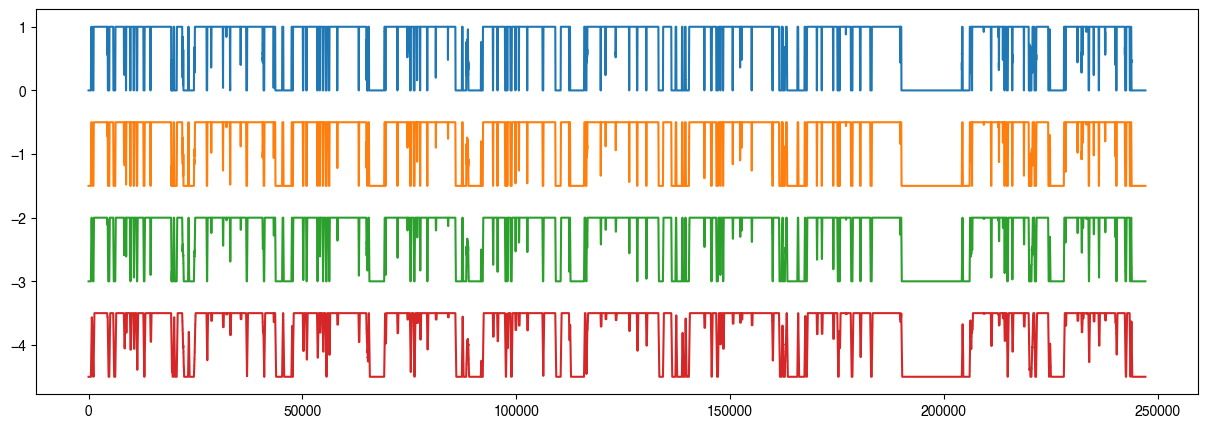

In [17]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(data_features_df['right']['outfb0'].values)
ax.plot(data_features_df['right']['outfb1'].values - 1.5)
ax.plot(data_features_df['right']['outfb2'].values - 3)
ax.plot(data_features_df['right']['outfb3'].values - 4.5)